In [1]:
import tensorflow as tf
import glob
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt 

In [36]:
#import image
images = []

for file_name in glob.glob('/Users/murray/Desktop/catdog/preprograss12/cat*.jpg'):
    im = mpimg.imread(file_name)
    im = im/255.0
    im = im[:,:, np.newaxis]
    images.append(im)
    
for file_name in glob.glob('/Users/murray/Desktop/catdog/preprograss12/dog*.jpg'):
    im = mpimg.imread(file_name)
    im = im/255.0
    im = im[:,:, np.newaxis]
    images.append(im)

labels = []
cat = [1, 0]
dog = [0, 1]

for i in range(12500):
    labels.append(cat)

for i in range(12500):
    labels.append(dog)
  

Input = np.array(images)
Labels = np.array(labels)

print (Input.shape)
print (Labels.shape)

(25000, 28, 28, 1)
(25000, 2)


In [37]:
np.save("/Users/murray/Desktop/catdog/Input1.npy",Input)
np.save("/Users/murray/Desktop/catdog/Labels1.npy",Labels)

In [2]:
Input = np.load("/Users/murray/Desktop/catdog/Input1.npy")
Labels = np.load("/Users/murray/Desktop/catdog/Labels1.npy")
print(Input.shape)
print(Labels.shape)

(25000, 28, 28, 1)
(25000, 2)


In [3]:
print(Input[5])

[[[ 0.03137255]
  [ 0.02745098]
  [ 0.03529412]
  [ 0.02745098]
  [ 0.03529412]
  [ 0.56862745]
  [ 0.89019608]
  [ 0.03921569]
  [ 0.03137255]
  [ 0.02745098]
  [ 0.03529412]
  [ 0.17647059]
  [ 0.64705882]
  [ 0.03529412]
  [ 0.04705882]
  [ 0.04313725]
  [ 0.04313725]
  [ 0.05098039]
  [ 0.07843137]
  [ 0.11764706]
  [ 0.19607843]
  [ 0.21960784]
  [ 0.26666667]
  [ 0.2745098 ]
  [ 0.21960784]
  [ 0.28627451]
  [ 0.02352941]
  [ 0.03137255]]

 [[ 0.02745098]
  [ 0.03529412]
  [ 0.03921569]
  [ 0.01960784]
  [ 0.02745098]
  [ 0.65882353]
  [ 0.60392157]
  [ 0.        ]
  [ 0.12941176]
  [ 0.14901961]
  [ 0.01960784]
  [ 0.44705882]
  [ 0.54509804]
  [ 0.03529412]
  [ 0.03137255]
  [ 0.03529412]
  [ 0.04705882]
  [ 0.05490196]
  [ 0.08235294]
  [ 0.12156863]
  [ 0.2       ]
  [ 0.22745098]
  [ 0.2745098 ]
  [ 0.28627451]
  [ 0.28235294]
  [ 0.33333333]
  [ 0.03921569]
  [ 0.03137255]]

 [[ 0.03921569]
  [ 0.03137255]
  [ 0.02352941]
  [ 0.03529412]
  [ 0.04705882]
  [ 0.6745098 ]
  [ 

In [3]:
print(Input[1].shape)
print(Input.shape)

(28, 28, 1)
(25000, 28, 28, 1)


# 参数设定

In [4]:
# Training Parameters
learning_rate = 0.001
num_steps = 500
batch_size = 256
display_step = 10
numOfEpoch = 100

# Network Parameters
num_classes = 2 
dropout = 0.75 # Dropout, probability to keep units

# tf Graph input
X = tf.placeholder(tf.float32, [None, 28,28,1])
Y = tf.placeholder(tf.float32, [None, num_classes])
keep_prob = tf.placeholder(tf.float32) # dropout (keep probability)

In [5]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')

In [6]:
def conv_net(x, weights, biases, dropout):
    # Tensor input become 4-D: [Batch Size, Height, Width, Channel]

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)

    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Apply Dropout
    fc1 = tf.nn.dropout(fc1, dropout)

    # Output, class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

In [7]:
# Store layers weight & bias
weights = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.get_variable("Wc1", shape=[5,5,1,32], initializer=tf.contrib.layers.xavier_initializer()),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': tf.get_variable("Wc2", shape=[5, 5, 32, 64], initializer=tf.contrib.layers.xavier_initializer()),
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': tf.get_variable("Wd1", shape=[7*7*64,1024], initializer=tf.contrib.layers.xavier_initializer()),
    # 1024 inputs, 10 outputs (class prediction)
    'out': tf.get_variable("Wout", shape=[1024, num_classes],initializer=tf.contrib.layers.xavier_initializer())
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([num_classes]))
}

# Construct model
logits = conv_net(X, weights, biases, keep_prob)
prediction = tf.nn.softmax(logits)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss_op)


# Evaluate model
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

#Saver use to store the model
saver = tf.train.Saver() 

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    for epoch in range(1, numOfEpoch):
        train_x, val_x, train_y, val_y = train_test_split(Input, Labels, test_size = 0.1)   
        
        for i in range(0, len(train_x), batch_size):
            trainLoss, _ = sess.run([loss_op, optimizer], feed_dict = {
                X: train_x[i: i+batch_size],
                Y: train_y[i: i+batch_size],
                keep_prob: dropout
            })
            if i % 5 == 0:
                print("The step is in "+ str(i)+ " step")
        
        valAcc, valLoss = sess.run([accuracy, loss_op], feed_dict={
            X: val_x,
            Y: val_y,
            keep_prob: 1.0})
             
        print("Step " + str(epoch) + ", Minibatch Loss= " + \
                  "{:.4f}".format(valLoss) + ", Training Accuracy= " + \
                  "{:.3f}".format(valAcc))
            
    print("Optimization Finished!")
    saver.save(sess, "../model.ckpt")  



The step is in 0 step
The step is in 1280 step
The step is in 2560 step
The step is in 3840 step
The step is in 5120 step
The step is in 6400 step
The step is in 7680 step
The step is in 8960 step
The step is in 10240 step
The step is in 11520 step
The step is in 12800 step
The step is in 14080 step
The step is in 15360 step
The step is in 16640 step
The step is in 17920 step
The step is in 19200 step
The step is in 20480 step
The step is in 21760 step
Step 1, Minibatch Loss= 0.6934, Training Accuracy= 0.501
The step is in 0 step
The step is in 1280 step
The step is in 2560 step
The step is in 3840 step
The step is in 5120 step
The step is in 6400 step
The step is in 7680 step
The step is in 8960 step
The step is in 10240 step
The step is in 11520 step
The step is in 12800 step
The step is in 14080 step
The step is in 15360 step
The step is in 16640 step
The step is in 17920 step
The step is in 19200 step
The step is in 20480 step
The step is in 21760 step
Step 2, Minibatch Loss= 0.692

The step is in 0 step
The step is in 1280 step
The step is in 2560 step
The step is in 3840 step
The step is in 5120 step
The step is in 6400 step
The step is in 7680 step
The step is in 8960 step
The step is in 10240 step
The step is in 11520 step
The step is in 12800 step
The step is in 14080 step
The step is in 15360 step
The step is in 16640 step
The step is in 17920 step
The step is in 19200 step
The step is in 20480 step
The step is in 21760 step
Step 17, Minibatch Loss= 0.5711, Training Accuracy= 0.703
The step is in 0 step
The step is in 1280 step
The step is in 2560 step
The step is in 3840 step
The step is in 5120 step
The step is in 6400 step
The step is in 7680 step
The step is in 8960 step
The step is in 10240 step
The step is in 11520 step
The step is in 12800 step
The step is in 14080 step
The step is in 15360 step
The step is in 16640 step
The step is in 17920 step
The step is in 19200 step
The step is in 20480 step
The step is in 21760 step
Step 18, Minibatch Loss= 0.5

The step is in 0 step
The step is in 1280 step
The step is in 2560 step
The step is in 3840 step
The step is in 5120 step
The step is in 6400 step
The step is in 7680 step
The step is in 8960 step
The step is in 10240 step
The step is in 11520 step
The step is in 12800 step
The step is in 14080 step
The step is in 15360 step
The step is in 16640 step
The step is in 17920 step
The step is in 19200 step
The step is in 20480 step
The step is in 21760 step
Step 33, Minibatch Loss= 0.4597, Training Accuracy= 0.786
The step is in 0 step
The step is in 1280 step
The step is in 2560 step
The step is in 3840 step
The step is in 5120 step
The step is in 6400 step
The step is in 7680 step
The step is in 8960 step
The step is in 10240 step
The step is in 11520 step
The step is in 12800 step
The step is in 14080 step
The step is in 15360 step
The step is in 16640 step
The step is in 17920 step
The step is in 19200 step
The step is in 20480 step
The step is in 21760 step
Step 34, Minibatch Loss= 0.4

The step is in 0 step
The step is in 1280 step
The step is in 2560 step
The step is in 3840 step
The step is in 5120 step
The step is in 6400 step
The step is in 7680 step
The step is in 8960 step
The step is in 10240 step
The step is in 11520 step
The step is in 12800 step
The step is in 14080 step
The step is in 15360 step
The step is in 16640 step
The step is in 17920 step
The step is in 19200 step
The step is in 20480 step
The step is in 21760 step
Step 49, Minibatch Loss= 0.2869, Training Accuracy= 0.894
The step is in 0 step
The step is in 1280 step
The step is in 2560 step
The step is in 3840 step
The step is in 5120 step
The step is in 6400 step
The step is in 7680 step
The step is in 8960 step
The step is in 10240 step
The step is in 11520 step
The step is in 12800 step
The step is in 14080 step
The step is in 15360 step
The step is in 16640 step
The step is in 17920 step
The step is in 19200 step
The step is in 20480 step
The step is in 21760 step
Step 50, Minibatch Loss= 0.2

In [ ]:
saver = tf.train.Saver()  
  
with tf.Session() as sess:  
    saver.restore(sess, "../model.ckpt") 
    loss, acc = sess.run([loss_op, accuracy], feed_dict={X: Input[0:10000], Y: Labels[0:10000], keep_prob: 1.0})
    print("loss is :")
    print(loss)
    print("accuracy is:")
    print(acc)

In [ ]:
saver = tf.train.Saver()  
  
with tf.Session() as sess:  
    saver.restore(sess, "../model.ckpt")
    preds = sess.run([prediction],feed_dict={X: Input[0:10], Y: Labels[0:10], keep_prob: 1.0})
    print(preds)

In [46]:
%matplotlib inline

In [48]:
def showImage(n):
    image = Input[n].reshape([28,28])
    plt.imshow(image)

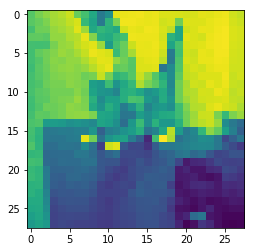

In [49]:
showImage(0)

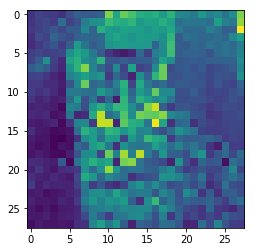

In [50]:
showImage(1)

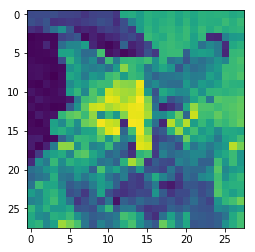

In [51]:
showImage(2)

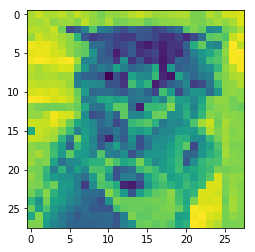

In [52]:
showImage(3)